In [1]:
# import modules
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from PIL import Image
import requests
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
import torch

import matplotlib.pyplot as plt

In [2]:
data_path = "/home/mingi/data/vistext/data/test_images/vertical"
file_names = sorted(os.listdir(data_path))

In [3]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    "ahmed-masry/chartgemma", torch_dtype=torch.float16
).cuda()
processor = AutoProcessor.from_pretrained("ahmed-masry/chartgemma")
# Format text inputs

/home/mingi/anaconda3/envs/tinyllava_factory/lib/python3.10/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
def inference_plot(model, processor, input_text, data_path, file_names, idx):

    # Encode chart figure and tokenize text
    image = Image.open(os.path.join(data_path, file_names[idx])).convert("RGB")
    inputs = processor(text=input_text, images=image, return_tensors="pt")
    prompt_length = inputs["input_ids"].shape[1]
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    # Generate
    generate_ids = model.generate(**inputs, num_beams=4, max_new_tokens=512)
    output_text = processor.batch_decode(
        generate_ids[:, prompt_length:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]
    print(output_text)

    plt.imshow(image)
    plt.axis("off")
    plt.show()

    "business": [
      {
        "business": "Volvo Car AB",
        "turnover": 470000
      },
        {
          "business": "Avisa Group AB",
          "turnover": 460000
        },
        {
          "business": "Axel Johnson Holding AB",
          "turnover": 460000
        },
        {
          "business": "Axel Johnson Holding AB",
          "turnover": 460000
        },
        {
          "business": "Axel Johnson Holding AB",
          "turnover": 460000
        },
        {
          "business": "Axel Johnson Holding AB",
          "turnover": 460000
        },
        {
          "business": "Axel Johnson Holding AB",
          "turnover": 460000
        },
        {
          "business": "Axel Johnson Holding AB",
          "turnover": 460000
        },
        {
          "business": "Axel Johnson Holding AB",
          "turnover": 460000
        },
        {
          "business": "Axel Johnson Holding AB",
          "turnover": 460000
        },
        {
          

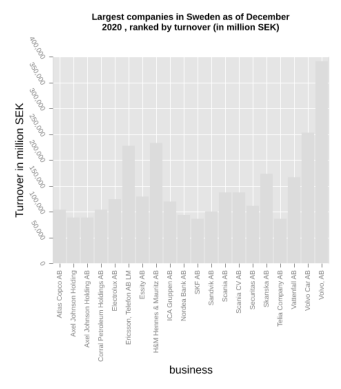

    "Year": [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], "Exchange rate (SGD to Euro)": [2.0, 1.8, 1.6, 1.6, 1.7, 1.5, 1.6, 1.6, 1.5, 1.5]
    }


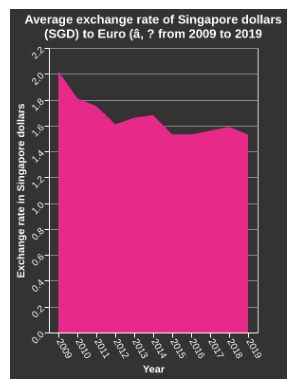

  "Year": 1990, "Deaths": 2, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volcanic eruption in Columbia (Nov)": 23000, "Volc

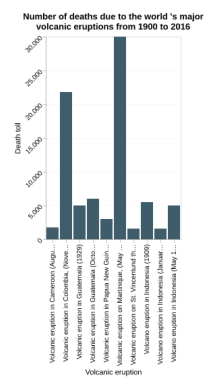

year: 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017}


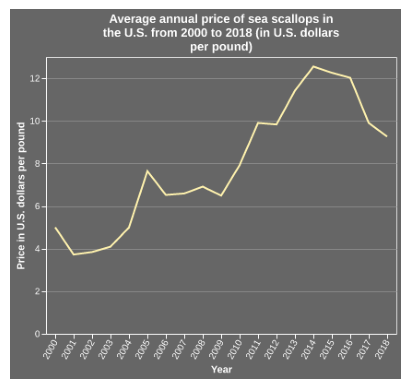

"country": "Australia", "number of publications": 250000, "country": "Brazil", "number of publications": 100000, "country": "Canada", "number of publications": 350000, "country": "France", "number of publications": 300000, "country": "Germany", "number of publications": 250000, "country": "Italy", "number of publications": 200000, "country": "Japan", "number of publications": 250000, "country": "Italy", "number of publications": 200000, "country": "United States", "number of publications": 150000, "country": "United Kingdom", "number of publications": 100000 }


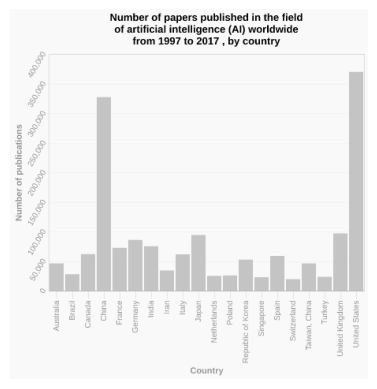

 'Chelyabinsk': 3.0, 'Kazan': 2.6, 'Kasperskya': 3.2, 'Moscow': 2.9, 'Nauru': 3.0, 'Novosibirsk': 3.4, 'Omsk': 3.6, 'perm': 3.1, 'Rostov-on-Don': 3.0, 'Saint Petersburg': 3.0, 'Samara': 3.0, 'Ufa': 3.0, 'Volgograd': 3.1, 'Voronezh': 3.0 }


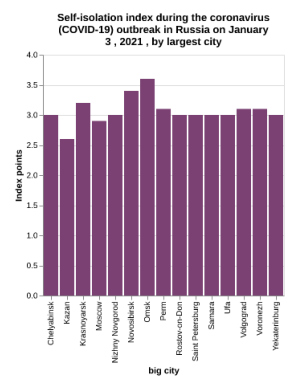

    "year": [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], "home attendance": [500000, 500000, 500000, 500000, 500000, 500000, 500000, 500000, 500000, 500000, 500000, 500000, 500000]
}


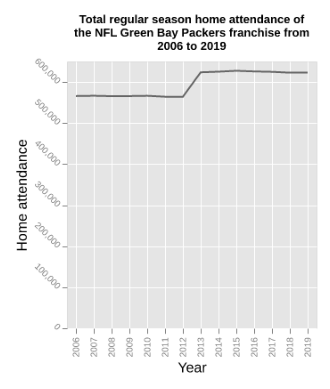

"Year": [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], "Number of Residents": [2100000, 2100000, 2100000, 2100000, 2100000, 2100000, 2200000, 2300000, 2400000] }


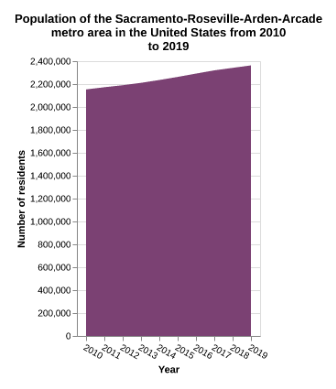

 'Action' : 9, 'Adventure' : 5.5, 'Fighting' : 1, 'Puzzle' : 1, 'Racing' : 0.5, 'Strategy' : 2, 'Simulation' : 2.5, 'Strategy Game' : 9 }


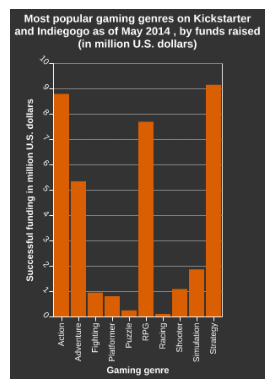

"Year": [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019], "Imports (million U.S. dollars)": [900, 900, 800, 800, 700, 600, 500, 400, 300, 200, 200, 200, 200, 200, 200] }


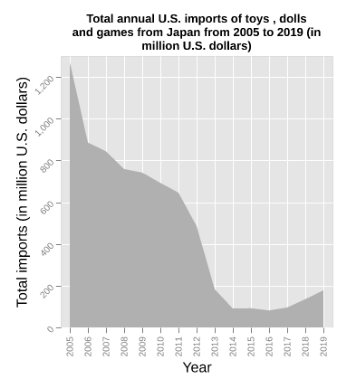

In [5]:
input_text = "Make a table that corresponds to this chart."
input_text = "Can you extract the data points from the chart in the image and convert them into a JSON format? : {"
# input_text = "convert the top of chart to a table"
for i in range(len(file_names)):
    if i == 10:
        break
    inference_plot(model, processor, input_text, data_path, file_names, idx=i)

In [13]:
def inference_2(model, processor, input_text, data_path, file_name):
    # Encode chart figure and tokenize text
    data_path = "/home/mingi/data/vistext/data/test_images"

    ver_image = Image.open(os.path.join(data_path, "vertical", file_name)).convert(
        "RGB"
    )
    ver_inputs = processor(text=input_text, images=ver_image, return_tensors="pt")
    ver_prompt_length = ver_inputs["input_ids"].shape[1]
    ver_inputs = {k: v.to("cuda") for k, v in ver_inputs.items()}

    hor_image = Image.open(os.path.join(data_path, "horizontal", file_name)).convert(
        "RGB"
    )
    hor_inputs = processor(text=input_text, images=hor_image, return_tensors="pt")
    hor_prompt_length = hor_inputs["input_ids"].shape[1]
    hor_inputs = {k: v.to("cuda") for k, v in hor_inputs.items()}

    # Generate
    generate_ids = model.generate(**ver_inputs, num_beams=4, max_new_tokens=512)
    ver_output_text = processor.batch_decode(
        generate_ids[:, ver_prompt_length:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]
    print(ver_output_text)

    generate_ids = model.generate(**hor_inputs, num_beams=4, max_new_tokens=512)
    hor_output_text = processor.batch_decode(
        generate_ids[:, hor_prompt_length:],
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )[0]
    print(hor_output_text)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(ver_image)
    axes[0].axis("off")
    axes[1].imshow(hor_image)
    axes[1].axis("off")

    plt.show()

In [14]:
file_names[11]

'7411.png'

| Year | Average monthly data volume per mobile internet subscription (in megabytes) |
|---|---|
| 2009 | 50 |
| 2010 | 100 |
| 2011 | 150 |
| 2012 | 200 |
| 2013 | 250 |
| 2014 | 300 |
| 2015 | 400 |
| 2016 | 600 |
| 2017 | 800 |
| 2018 | 1500 |
| 2019 | 2000 |
| 2020 | 3000 |
| Year | Average monthly data volume per mobile internet subscription (in megabytes) |
|---|---|
| 2009 | 100 |
| 2010 | 100 |
| 2011 | 100 |
| 2012 | 100 |
| 2013 | 100 |
| 2014 | 200 |
| 2015 | 300 |
| 2016 | 500 |
| 2017 | 800 |
| 2018 | 1500 |
| 2019 | 2000 |
| 2020 | 3000 |


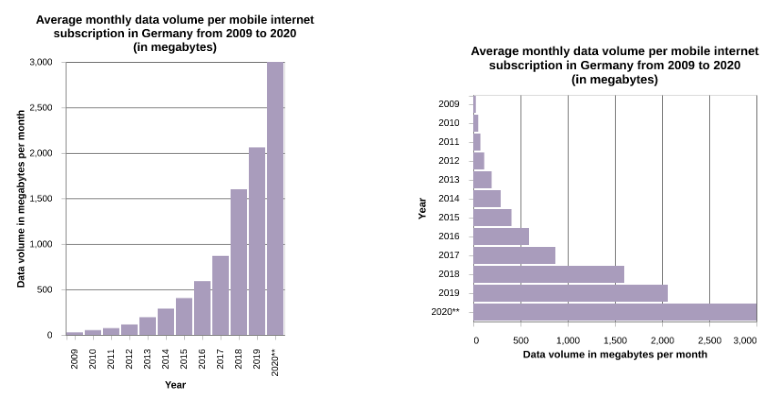

In [40]:
data_path = "/home/mingi/data/vistext/data/test_images/vertical"
input_text = "List all values of the chart."
input_text = "Values in the chart: "
# input_text = "Make a table that corresponds to this chart."
file_names = os.listdir(data_path)
# input_text = "convert the top of chart to a table"
for i, file_name in enumerate(file_names):
    file_name = file_names[500]
    inference_2(model, processor, input_text, data_path, file_name)
    if i == 0:
        break